In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
from septum_mec.analysis.plotting import plot_psth, plot_waveforms
import expipe
import os
import pathlib
import numpy as np
import exdir
from scipy.interpolate import interp1d
import pandas as pd
import optogenetics as og
import quantities as pq

14:58:24 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
par = {'speed_filter': 5, # m/s
    'pos_fs': 100 ,
    'f_cut': 6 ,
    'spat_binsize': 0.02 ,
    'grid_stepsize': 0.1 ,
    'box_xlen': 1 ,
    'box_ylen': 1 ,
    'spike_size': 10,
    'field_max_wall_extent':0.1,
    'field_min_bins':12
}

binsize = par['spat_binsize']
smoothing = 0.03
plt.rcParams['figure.figsize'] = (12,9)

In [4]:
project_path = os.environ.get("SEPTUM_MEC_DATA")
if project_path is None:
    raise Exception("Need to set `SEPTUM_MEC_DATA` as environment variable first.")
else:
    project_path = pathlib.Path(project_path)

project = expipe.get_project(project_path)
actions = project.actions

In [323]:
def psth(sptr, stim_times, start_time, stop_time, binsize, axs=None):
    if axs is None:
        fig, axs = plt.subplots(2, 1, sharex=True)
    
    spike_times = sptr.magnitude
    trials = [spike_times[(spike_times > t + start_time) & (spike_times <= t + stop_time)] - t for t in stim_times]
    trials_ids = [[i]*len(t) for i, t in enumerate(trials)]

    trials_flat = [s for t in trials for s in t]
    trials_ids_flat = [s for t in trials_ids for s in t]

    axs[1].scatter(trials_flat, trials_ids_flat, s=1)
    bins = np.arange(start_time, stop_time + binsize, binsize)
    axs[0].hist(trials_flat, bins=bins, density=True);
    axs[0].set_title('channel group {} {}'.format(
        sptr.annotations['group_id'], sptr.annotations['name']))
    return axs

In [6]:
action_id = "1833-050619-2"
channel_ids = range(8)
t_start = 0
t_stop = None

action  = actions[action_id]

data_path = dp.get_data_path(action)
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities, exdir.plugins.git_lfs])

epochs = dp.load_epochs(data_path)

In [7]:
print('stimulation periode', np.diff(epochs[0].times.magnitude).mean())
print('stimulation frequency', 1 / np.diff(epochs[0].times.magnitude).mean())

stimulation periode 0.09000341034103411
stimulation frequency 11.110690097307154


No spikes in channel group 0


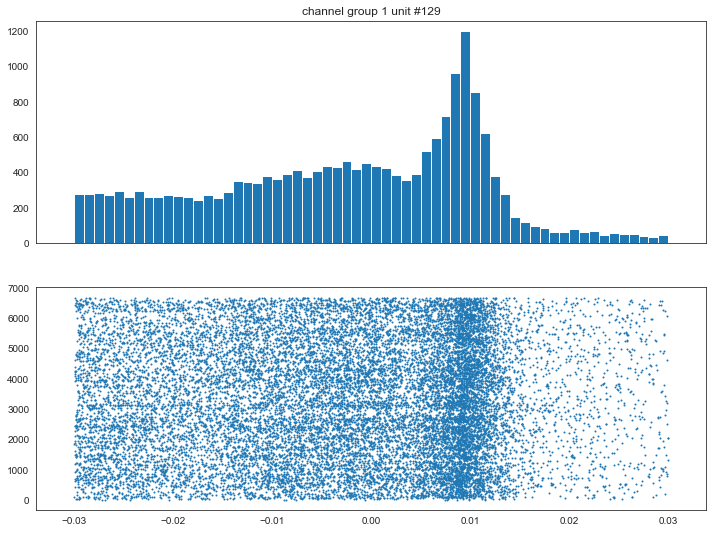

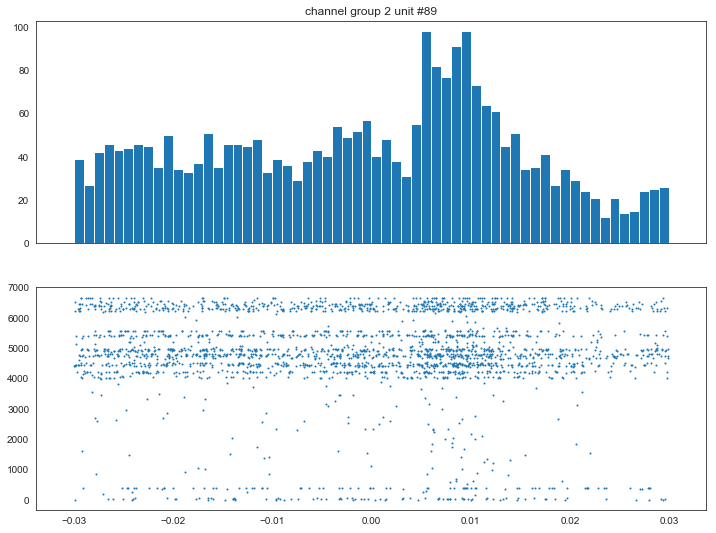

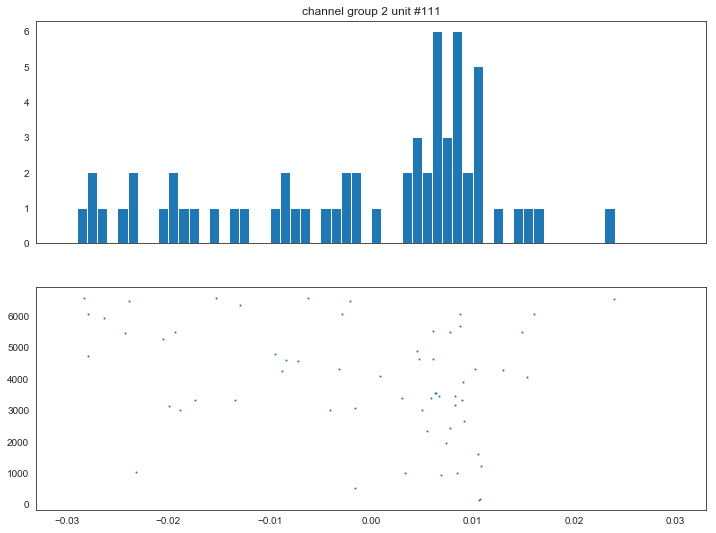

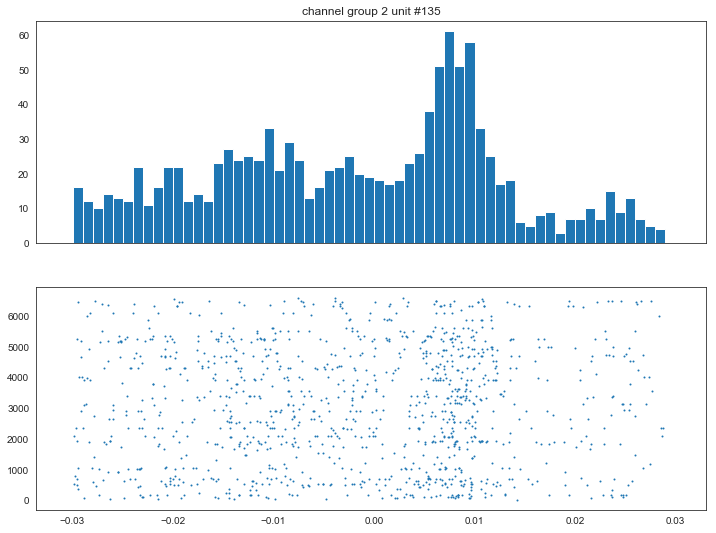

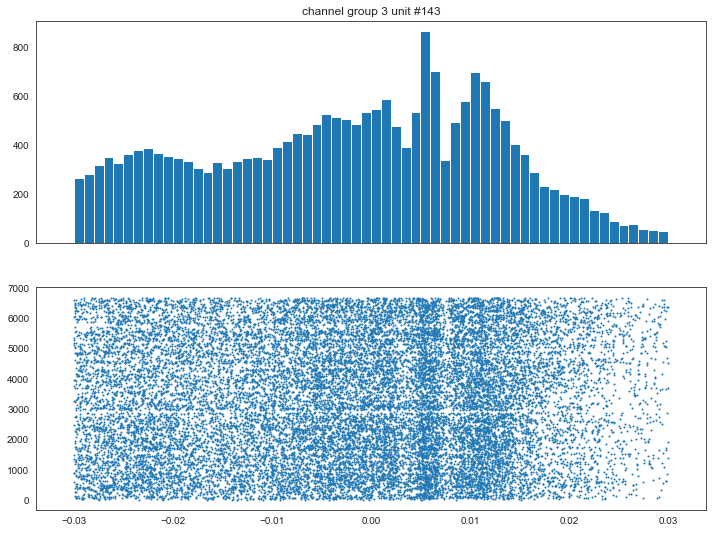

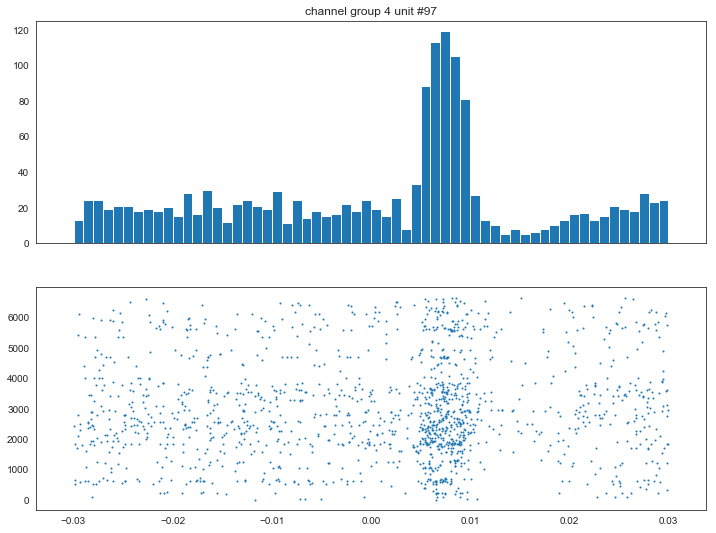

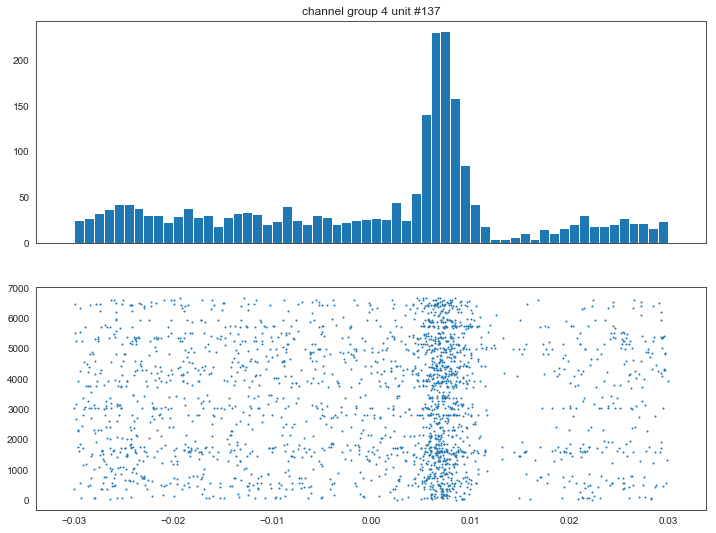

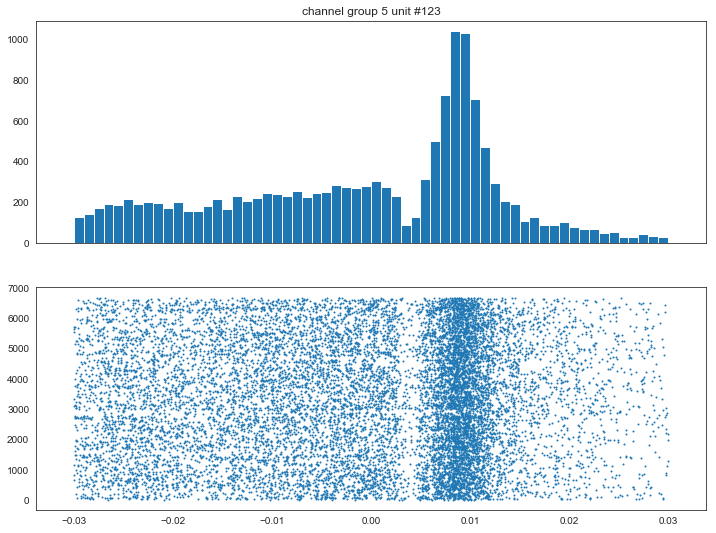

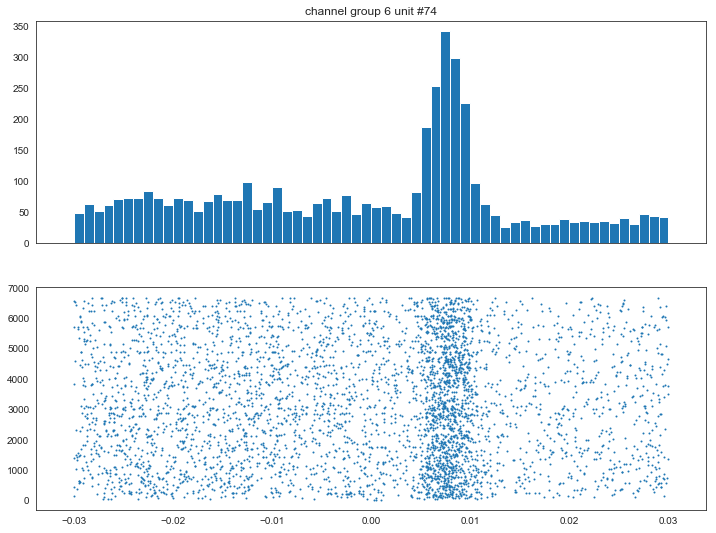

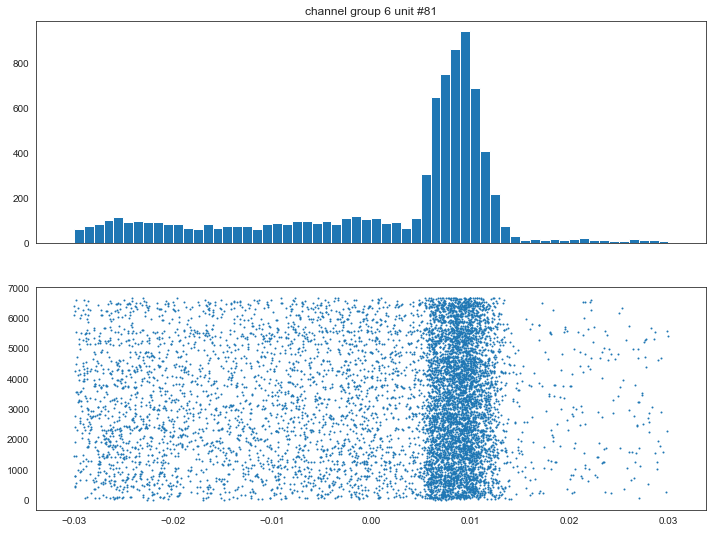

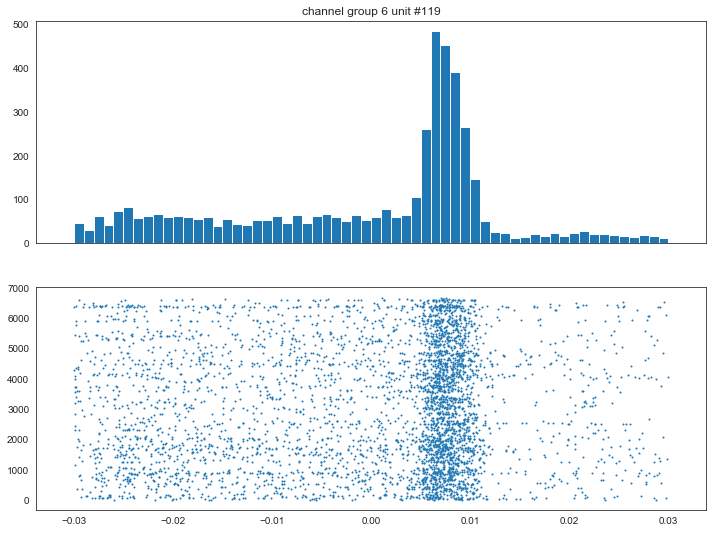

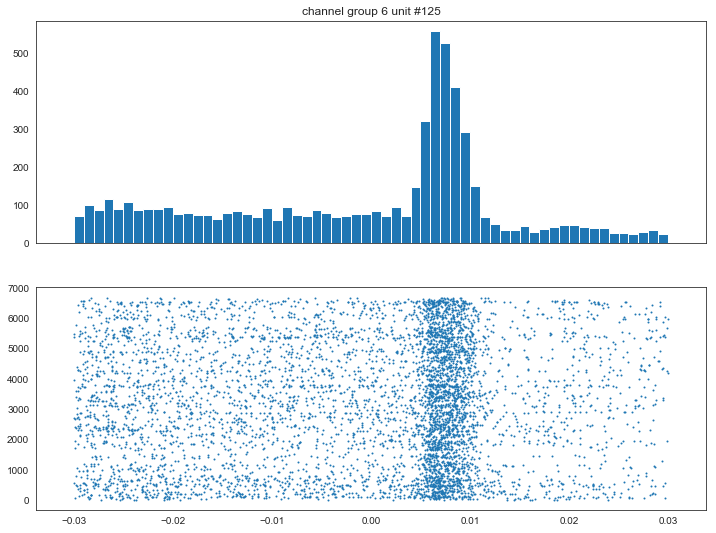

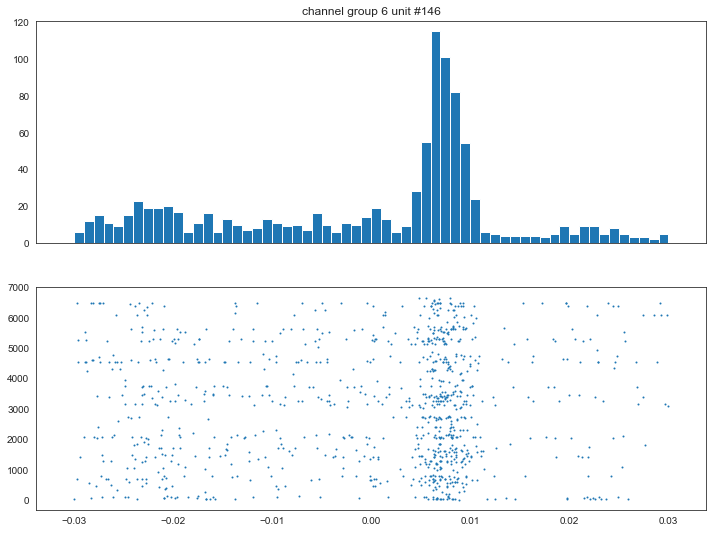

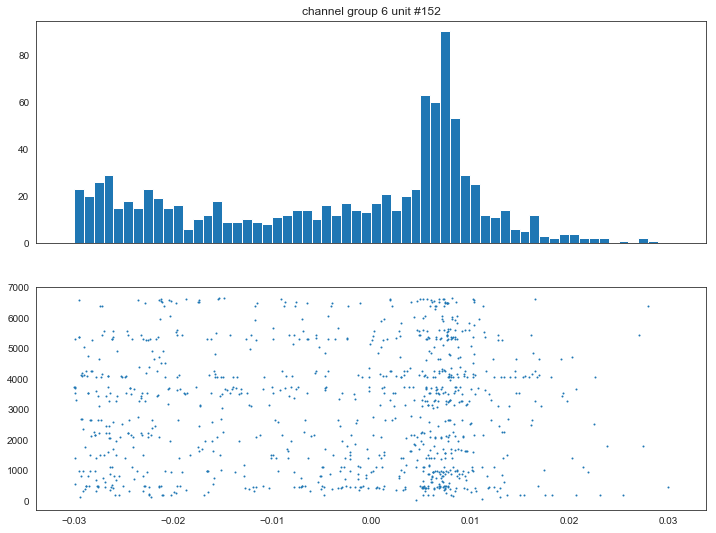

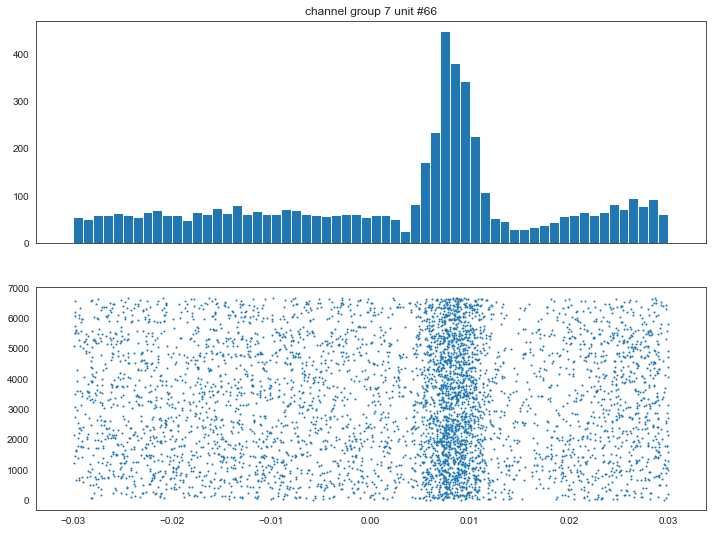

In [8]:
if t_start is not None and t_stop is not None:
    mask = (t < t_stop) & (t > t_start)
    x, y, t = x[mask], y[mask], t[mask]

for channel_id in channel_ids:
    spike_trains = dp.load_spiketrains(data_path, channel_id, load_waveforms=True)
    if len(spike_trains) == 0:
        print('No spikes in channel group {}'.format(channel_id))
        continue
            
    spike_trains = dp.sort_by_cluster_id(spike_trains)
    for spike_times in spike_trains:
        if t_start is not None and t_stop is not None:
            spike_mask = (spike_times < t_stop) & (spike_times > t_start)
            spike_times = spike_times[spike_mask]

        psth(spike_times, epochs[0].times.magnitude, -0.03, 0.03, 0.001)


In [11]:
def get_unit(channel_group, unit):
    unit = f'unit #{unit}'
    spike_trains = dp.load_spiketrains(data_path, channel_group, load_waveforms=False)
    u = [s for s in spike_trains if s.annotations['name']==unit]
    if len(u) == 1:
        return u[0]

In [12]:
from scipy.signal import find_peaks

In [423]:
from septum_mec.analysis.stimulus_response import stimulus_response_latency, compute_response

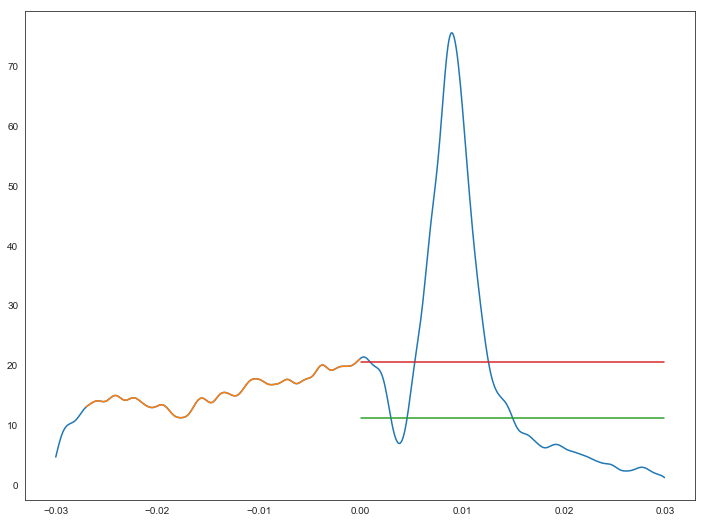

In [424]:
# unit = get_unit(6, 81)
unit = get_unit(5, 123)

stimulus_response_latency(unit, epochs[0], 0.03, 0.04, plot=True);

No spikes in channel group 0


<Figure size 864x648 with 0 Axes>

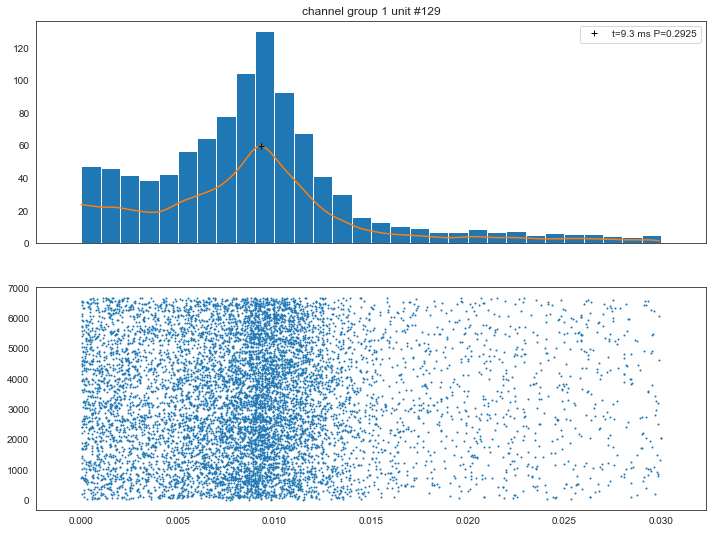

<Figure size 864x648 with 0 Axes>

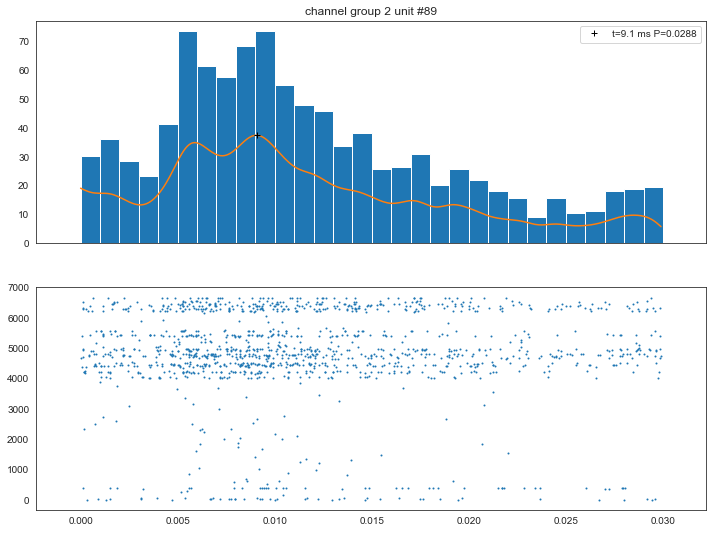

<Figure size 864x648 with 0 Axes>

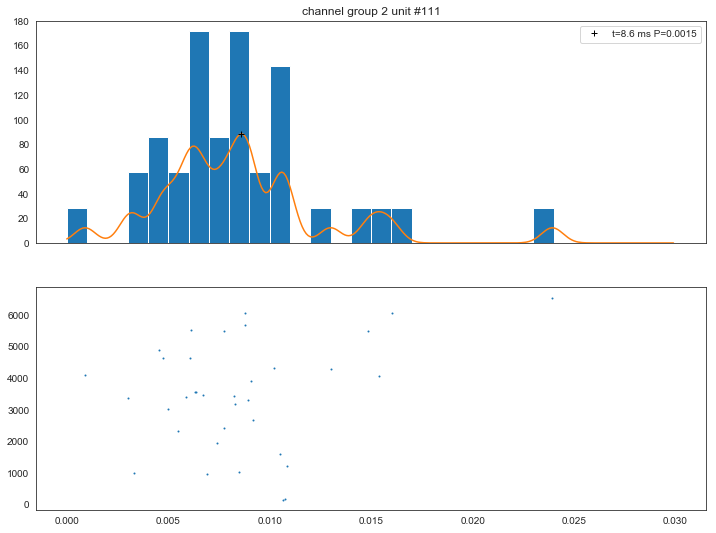

<Figure size 864x648 with 0 Axes>

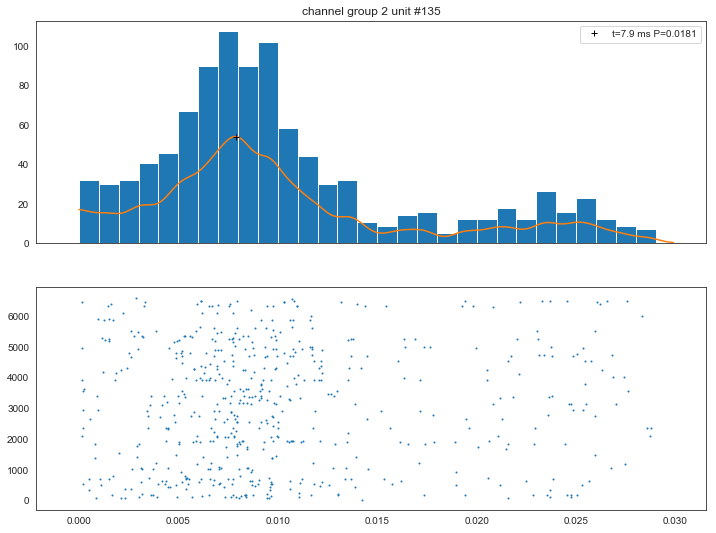

<Figure size 864x648 with 0 Axes>

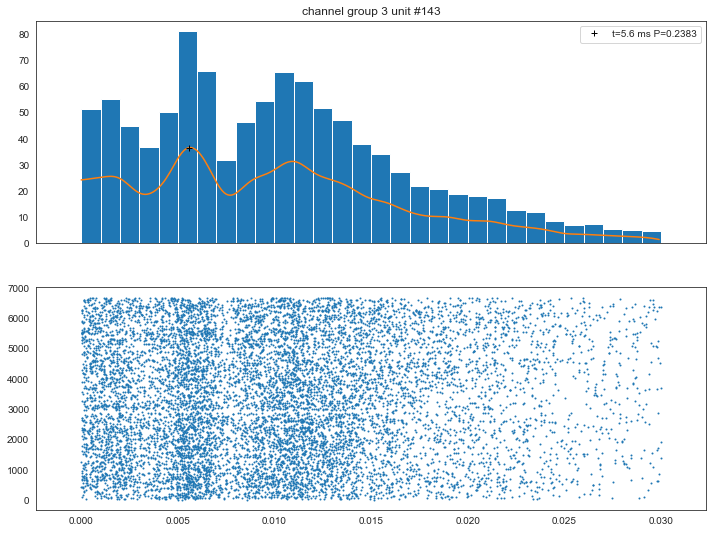

<Figure size 864x648 with 0 Axes>

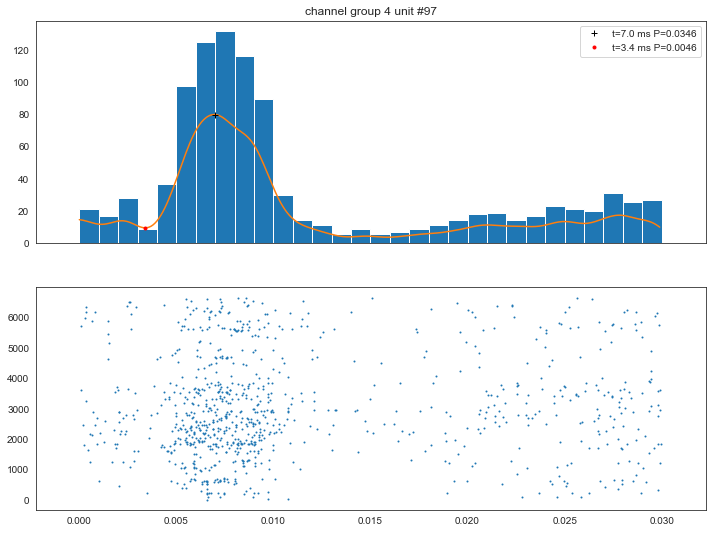

<Figure size 864x648 with 0 Axes>

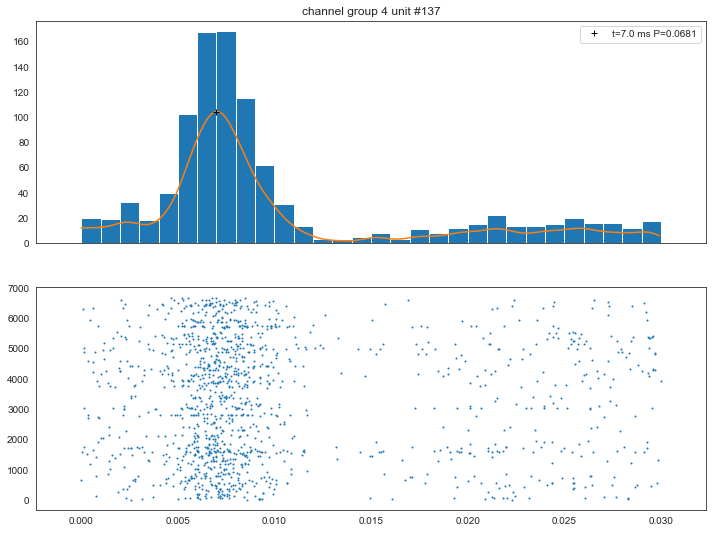

<Figure size 864x648 with 0 Axes>

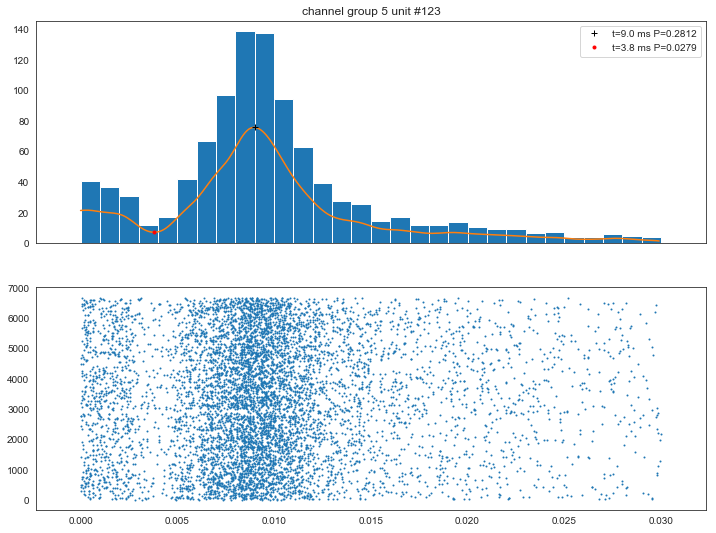

<Figure size 864x648 with 0 Axes>

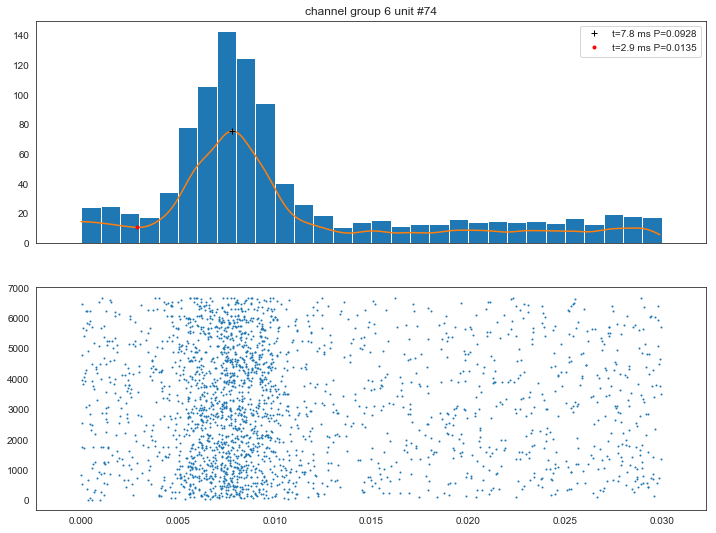

<Figure size 864x648 with 0 Axes>

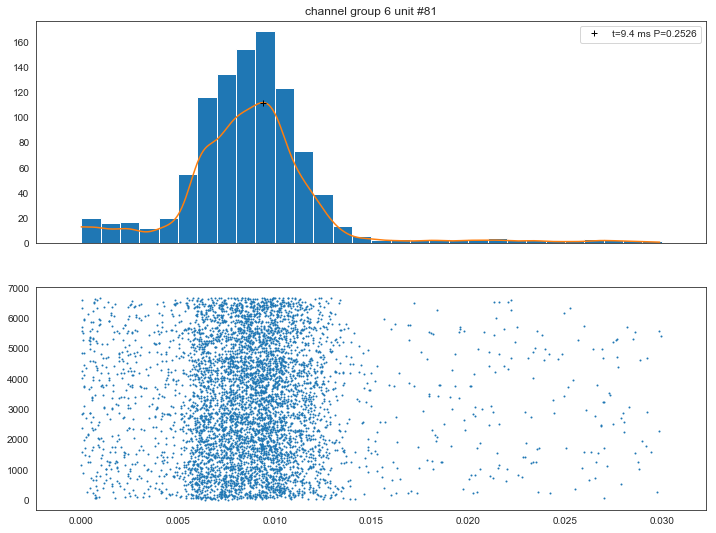

<Figure size 864x648 with 0 Axes>

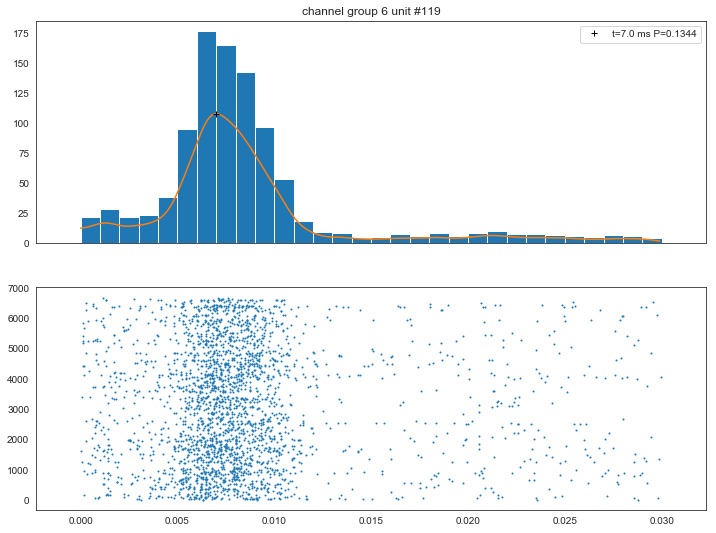

<Figure size 864x648 with 0 Axes>

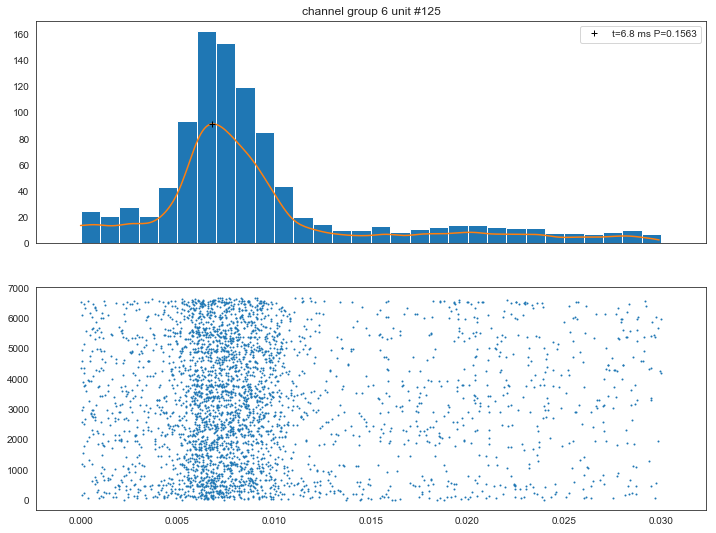

<Figure size 864x648 with 0 Axes>

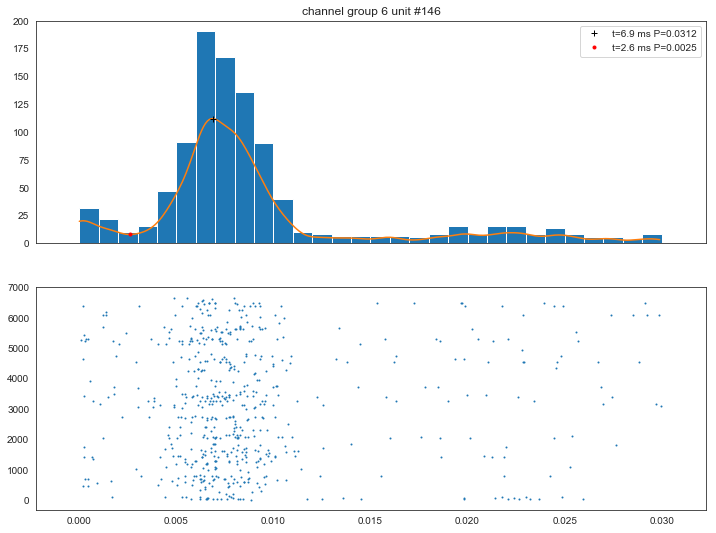

<Figure size 864x648 with 0 Axes>

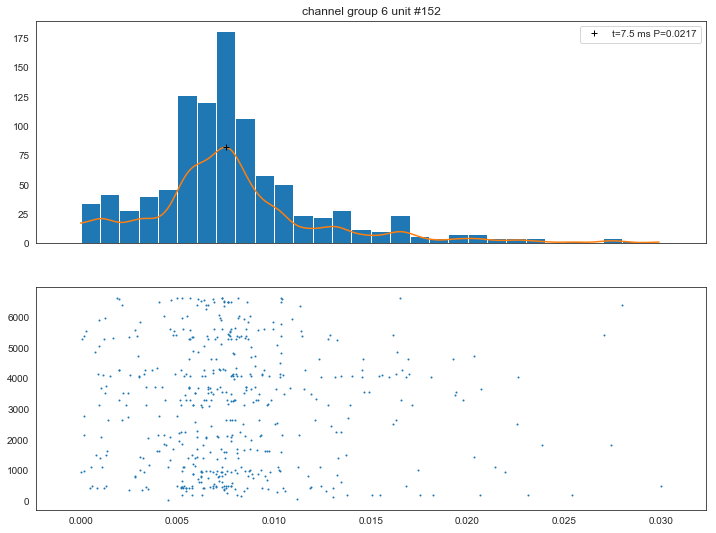

<Figure size 864x648 with 0 Axes>

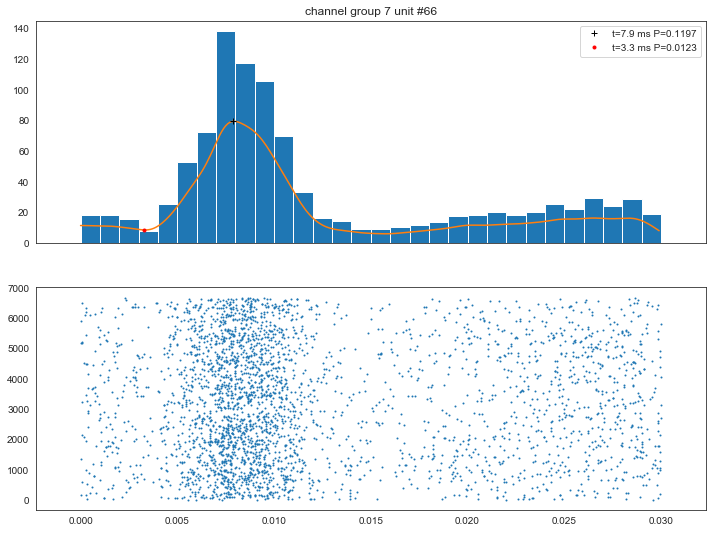

In [437]:
for channel_id in channel_ids:
    spike_trains = dp.load_spiketrains(data_path, channel_id, load_waveforms=True)
    if len(spike_trains) == 0:
        print('No spikes in channel group {}'.format(channel_id))
        continue
            
    spike_trains = dp.sort_by_cluster_id(spike_trains)
    for spike_times in spike_trains:
        
        plt.figure()
        axs = psth(spike_times, epochs[0].times.magnitude, 0, 0.03, 0.001)
        
        spike_times = np.array(spike_times)
        stim_times = np.array(epochs[0])
        
        times, spikes, kernel, p_e, p_i = stimulus_response_latency(
            spike_times, stim_times, 0.03, 0.04)
        hist = kernel(times)
        te_peak, pe_peak, ti_peak, pi_peak = compute_response(
            spike_times, stim_times, times, kernel, p_e, p_i)
        
        axs[0].plot(times, hist)
        axs[0].plot(
            te_peak, hist[times==te_peak], 
            marker='+', ls='None', color='k', 
            label=f't={te_peak * 1000:.1f} ms P={pe_peak:.4f}')
        
        if not np.isnan(ti_peak):
            axs[0].plot(
                ti_peak, hist[times==ti_peak], 
                marker='.', ls='None', color='red', 
                label=f't={ti_peak * 1000:.1f} ms P={pi_peak:.4f}')
            
        axs[0].legend()
#         break
#     break

#         sptr_name = spike_times.annotations['name']
#         plt.title(f'channel group {channel_id} {sptr_name}')

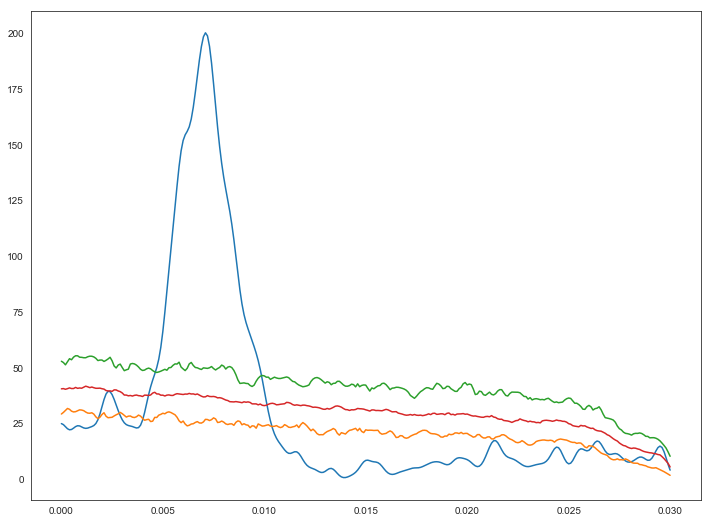

In [131]:
# unit = get_unit(5, 123)
# unit = get_unit(6, 125)
# unit = get_unit(3, 143)
unit = get_unit(4, 137)

time, hist, pe, pi = stimulus_response_latency_kde(unit, epochs[0], 0.03, 0.02, 0.04, plot=True)
# plt.xlim(0)


No spikes in channel group 0


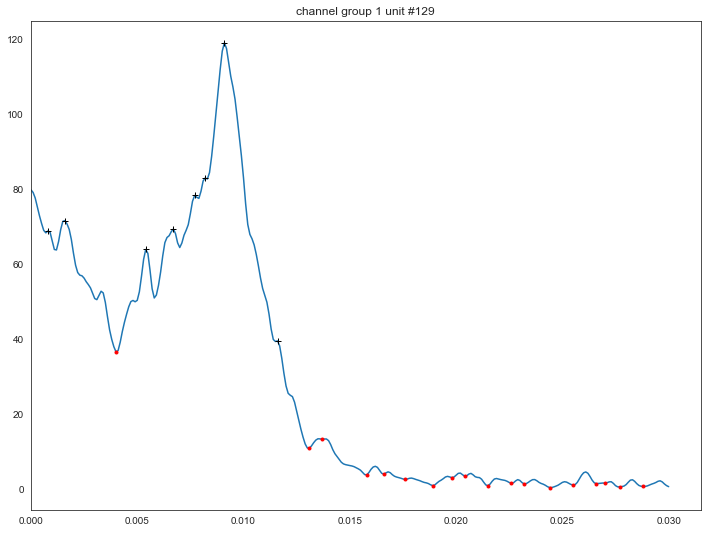

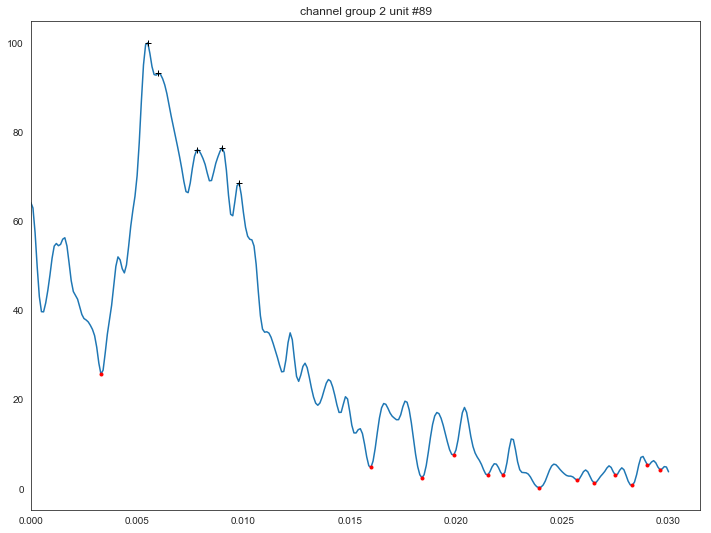

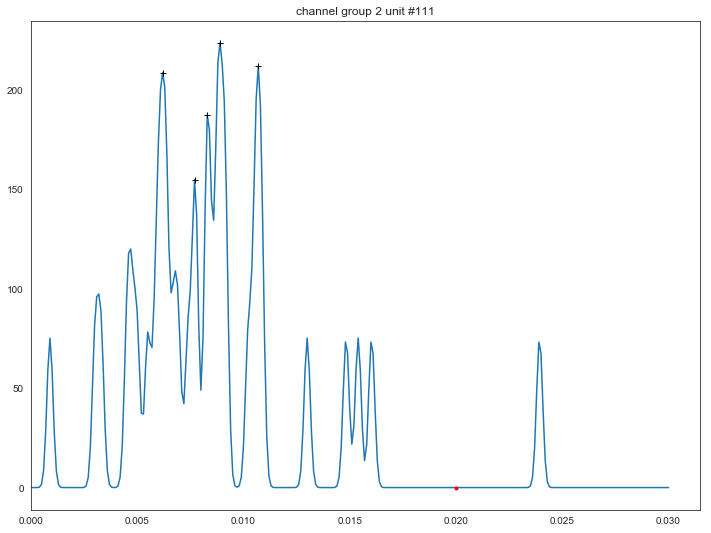

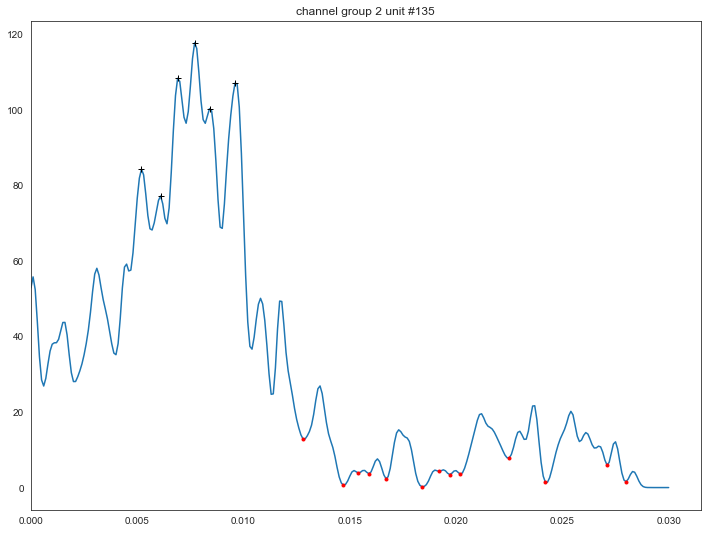

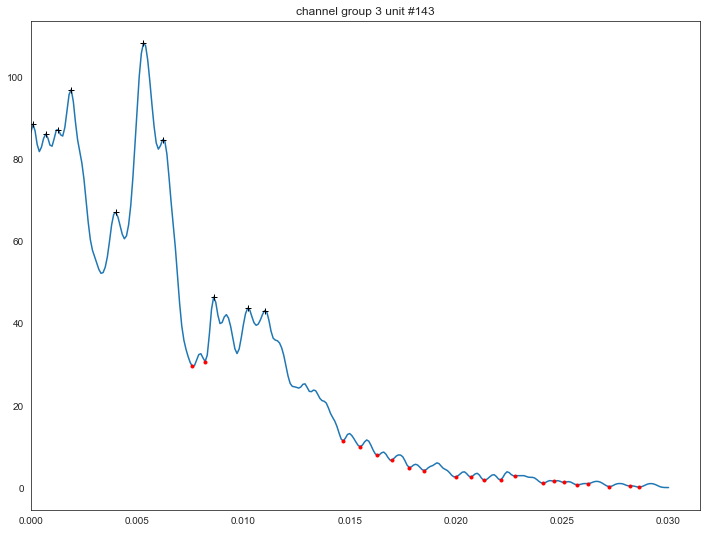

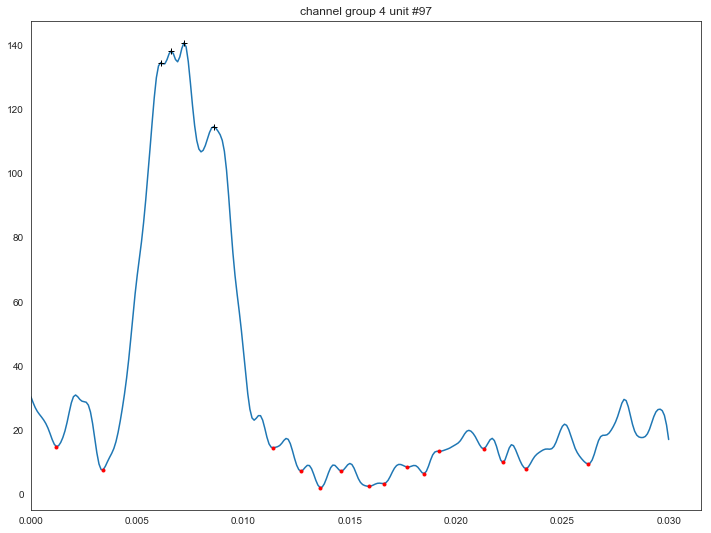

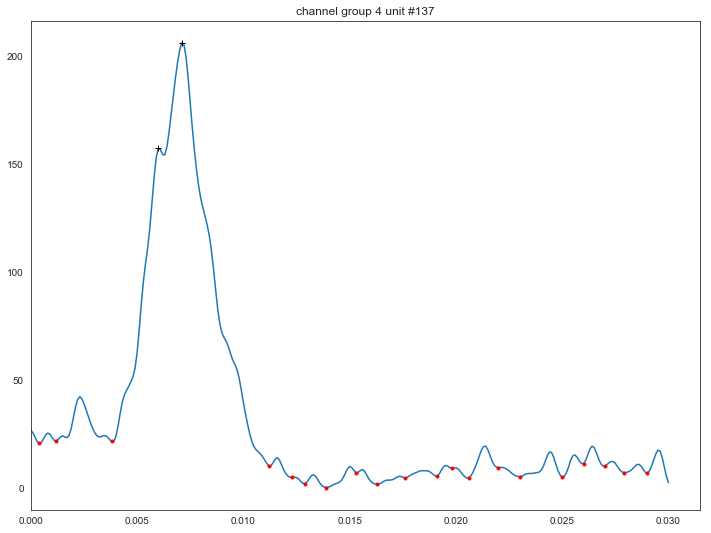

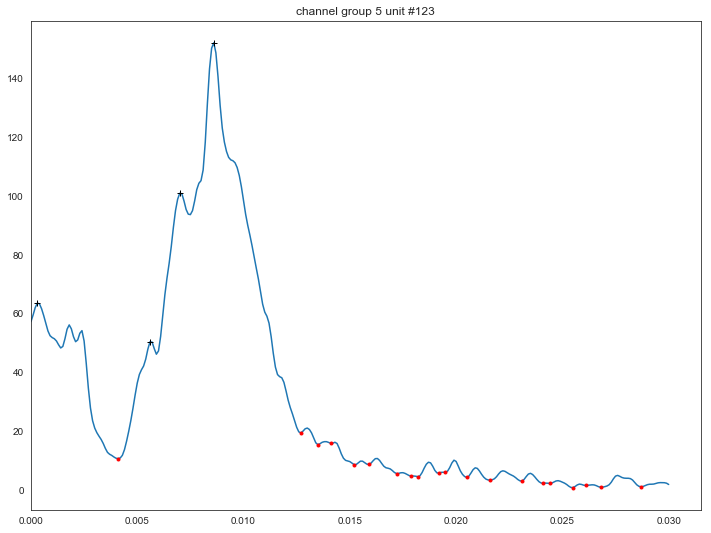

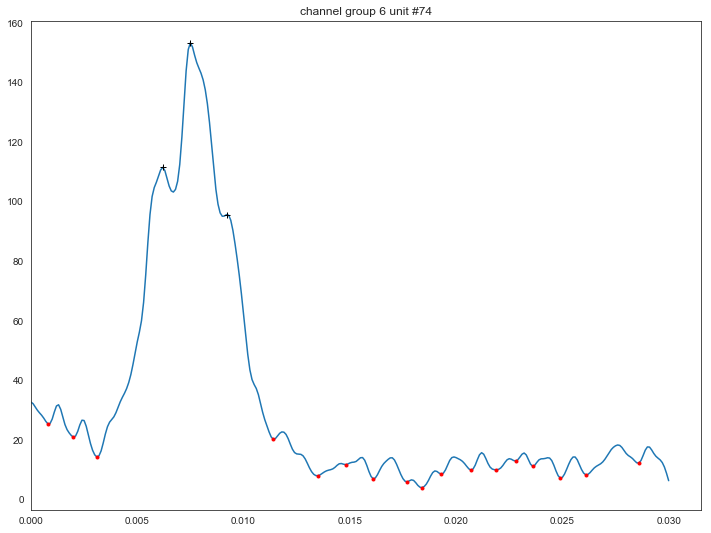

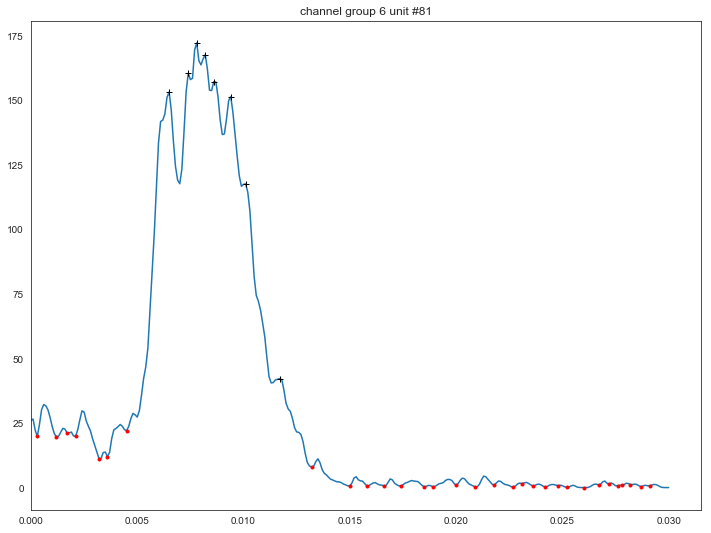

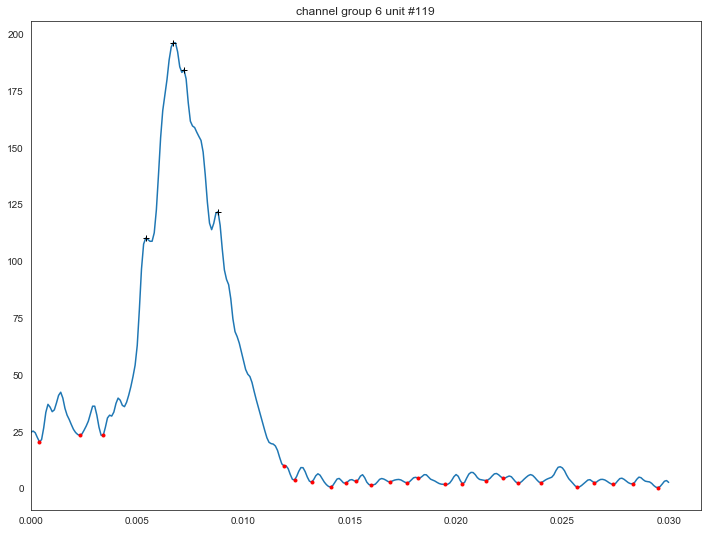

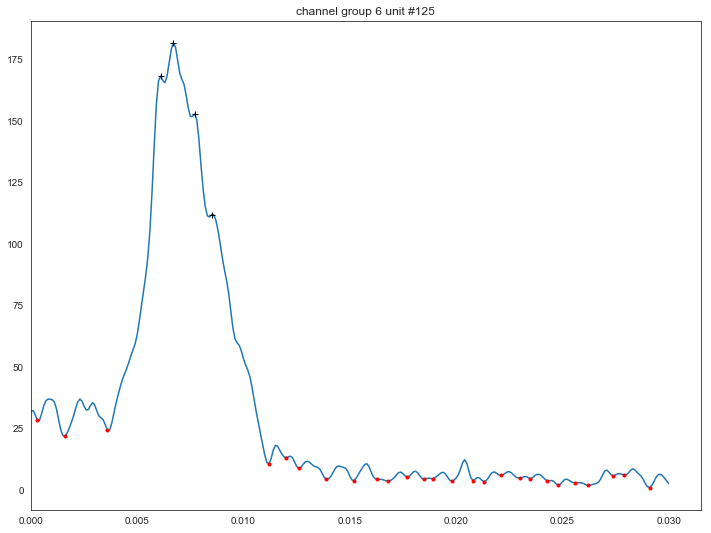

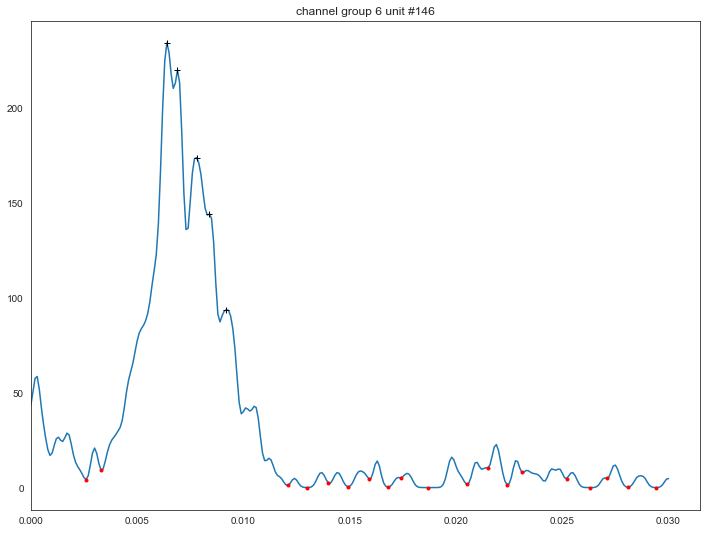

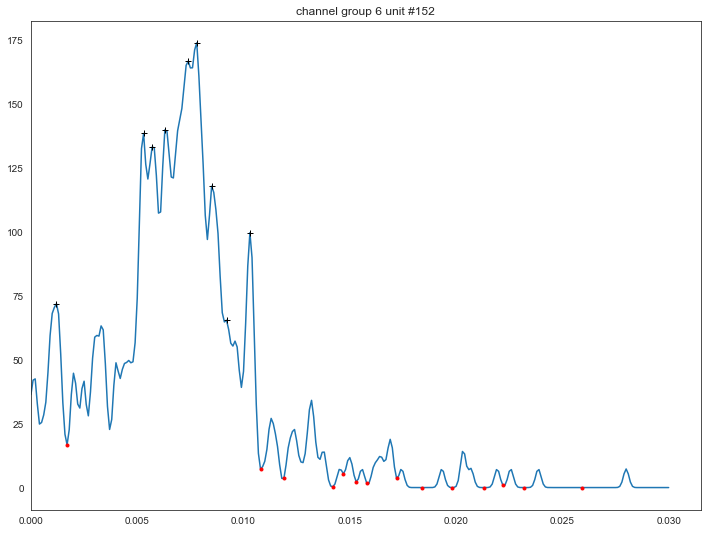

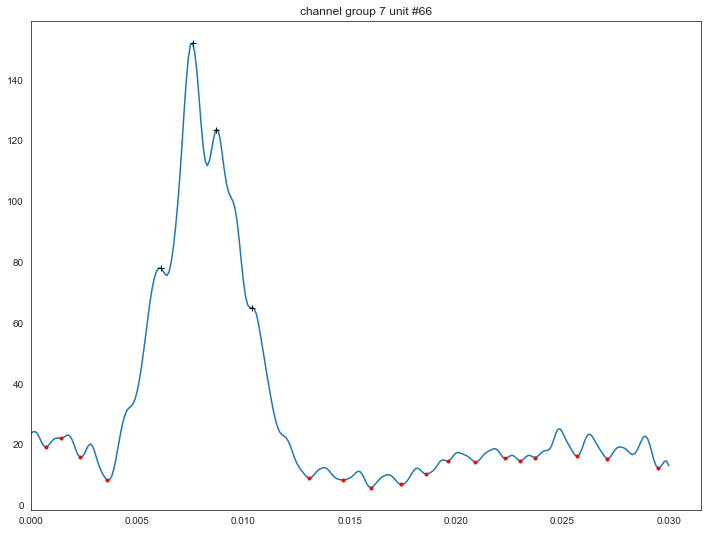

In [127]:
for channel_id in channel_ids:
    spike_trains = dp.load_spiketrains(data_path, channel_id, load_waveforms=True)
    if len(spike_trains) == 0:
        print('No spikes in channel group {}'.format(channel_id))
        continue
            
    spike_trains = dp.sort_by_cluster_id(spike_trains)
    for spike_times in spike_trains:

        time, hist, p_e, p_i = stimulus_response_latency_kde(spike_times, epochs[0], 0.03, 0.03, 0.03)
        
        plt.figure()
        plt.plot(time, hist)
        idxs_e, _ = find_peaks(hist)
        idxs_e = idxs_e[p_e[idxs_e] < 0.001]
        plt.plot(time[idxs_e], hist[idxs_e], marker='+', ls='None', color='k')

        idxs_i, _ = find_peaks(- hist)
        idxs_i = idxs_i[p_i[idxs_i] < 0.001]
        plt.plot(time[idxs_i], hist[idxs_i], marker='.', ls='None', color='red')
        plt.xlim(0)
        sptr_name = spike_times.annotations['name']
        plt.title(f'channel group {channel_id} {sptr_name}')

No spikes in channel group 0


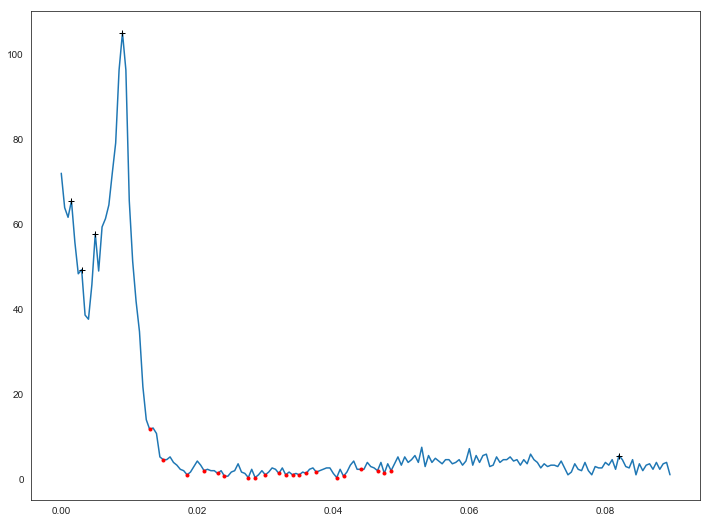

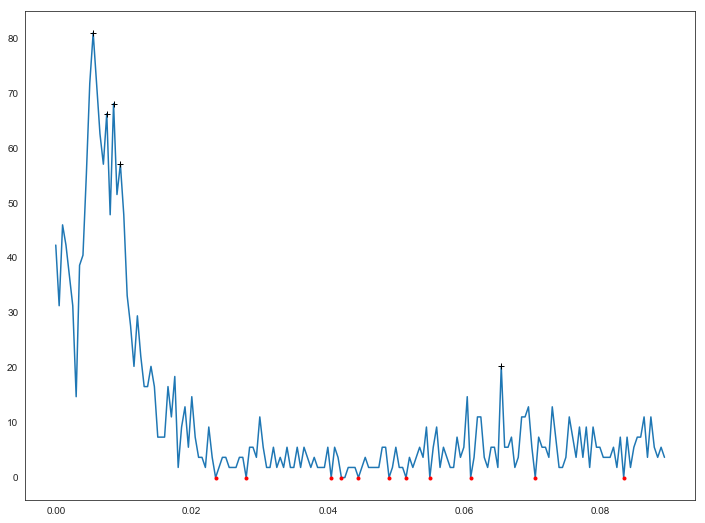

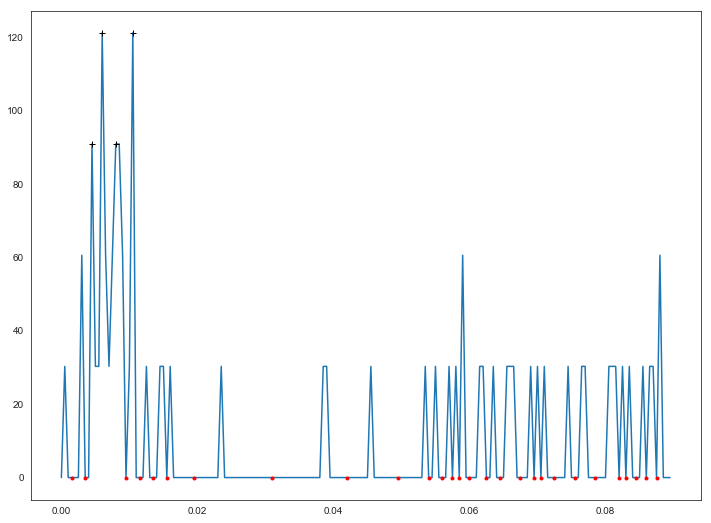

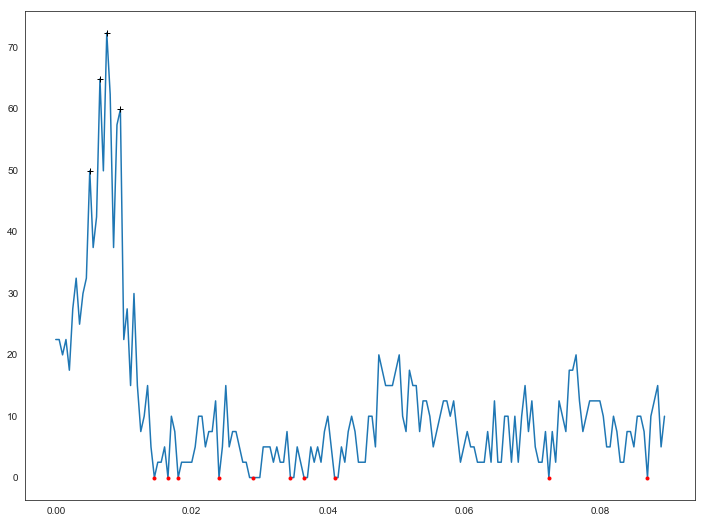

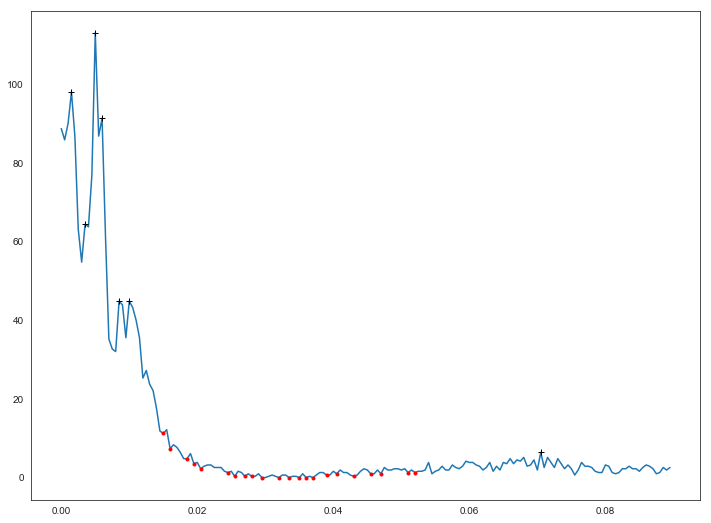

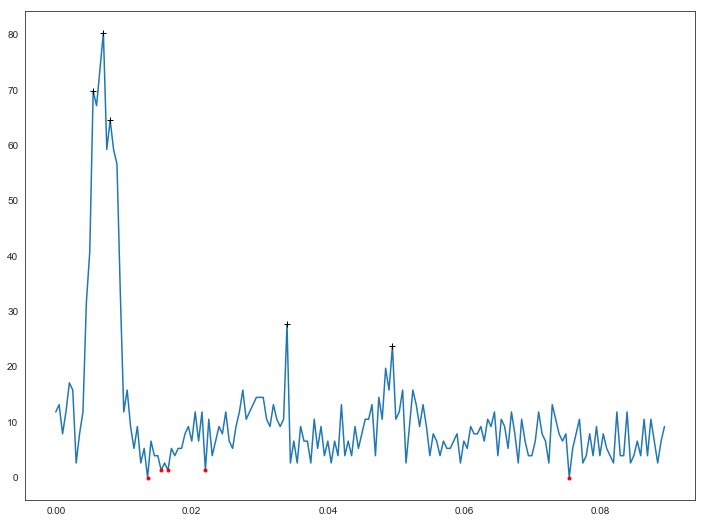

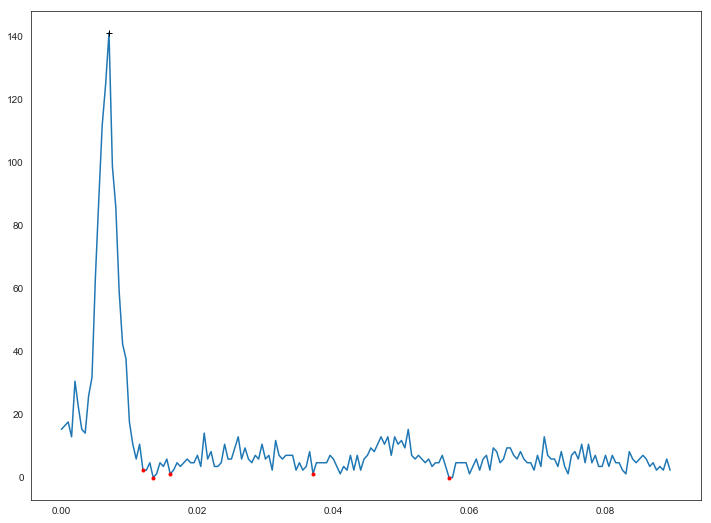

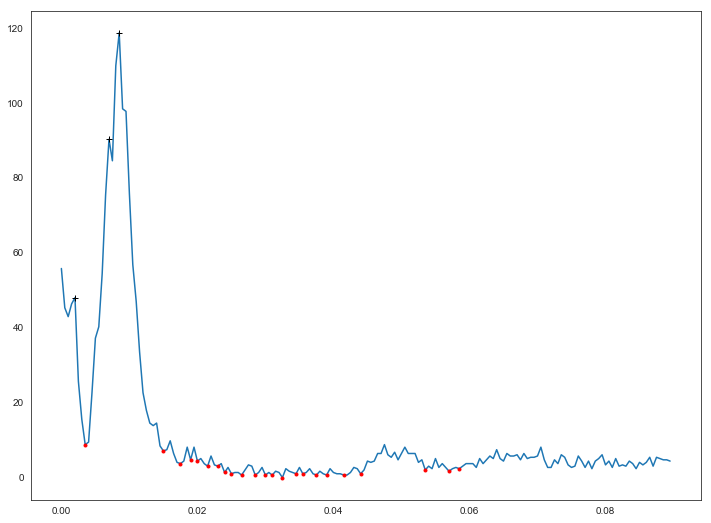

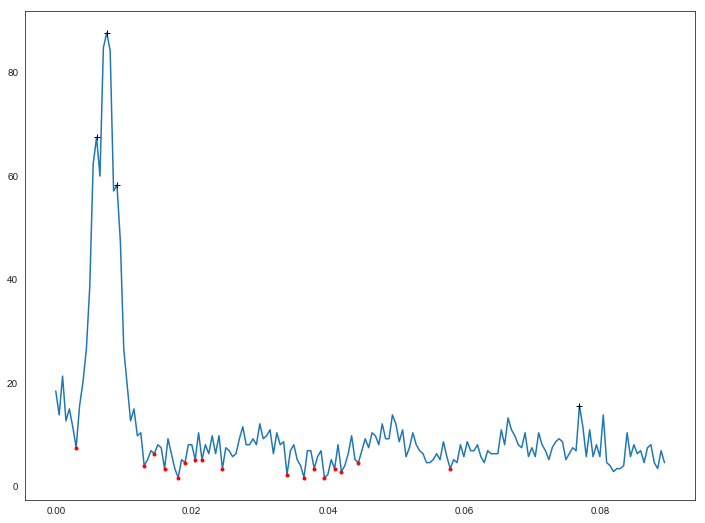

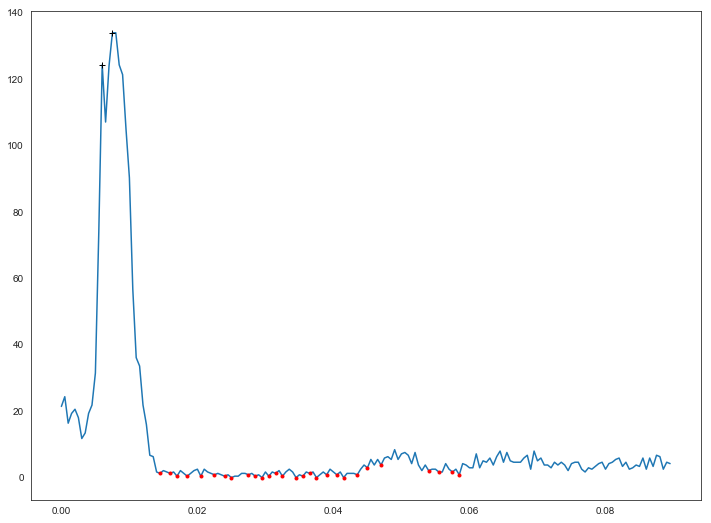

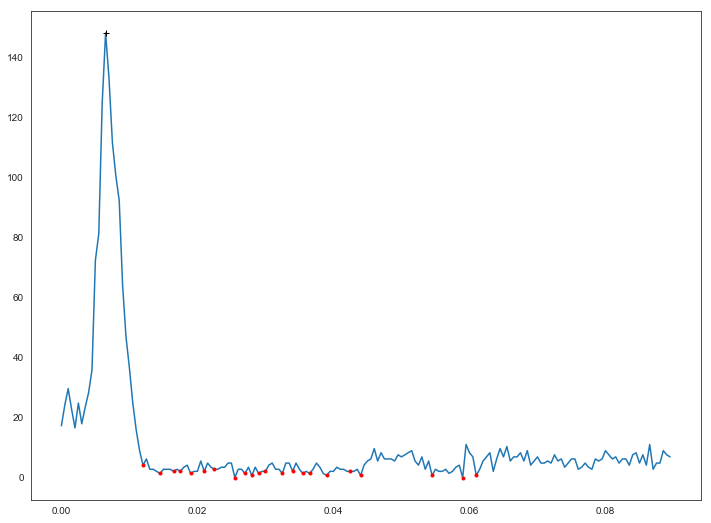

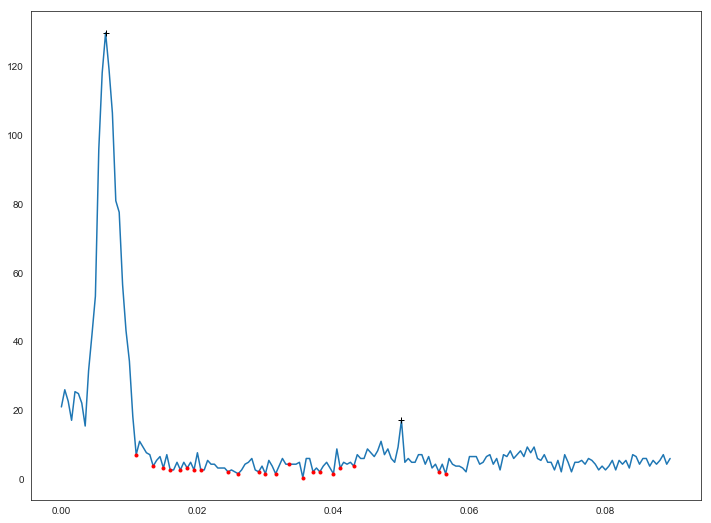

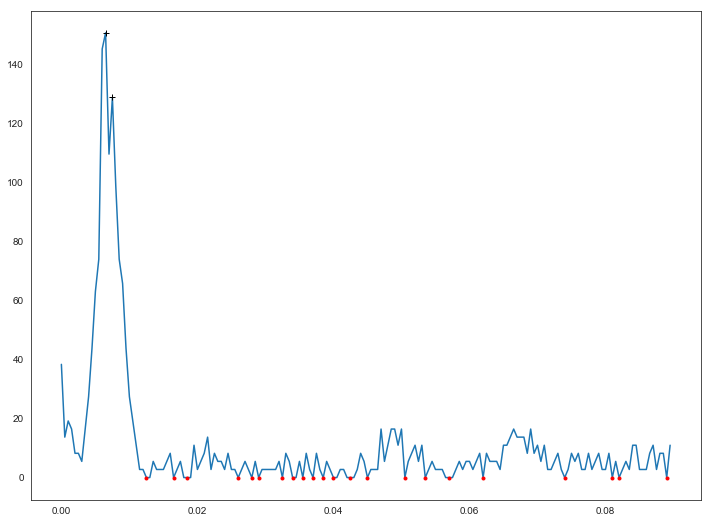

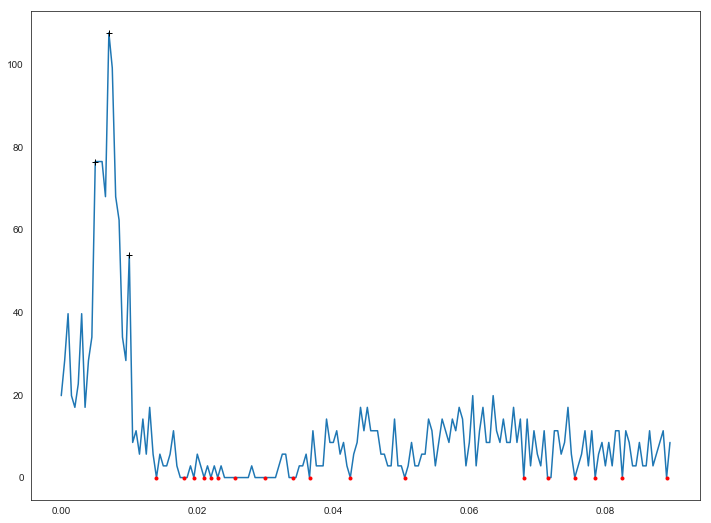

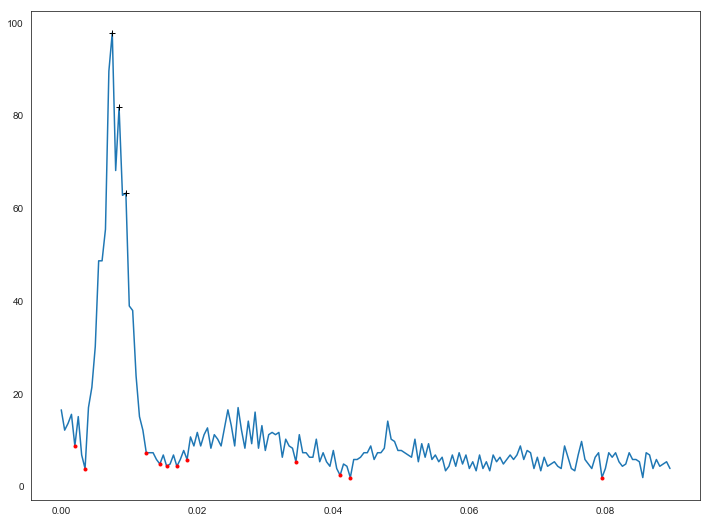

In [46]:
for channel_id in channel_ids:
    spike_trains = dp.load_spiketrains(data_path, channel_id, load_waveforms=True)
    if len(spike_trains) == 0:
        print('No spikes in channel group {}'.format(channel_id))
        continue
            
    spike_trains = dp.sort_by_cluster_id(spike_trains)
    for spike_times in spike_trains:

        time, hist, p_e, p_i = stimulus_response_latency(spike_times, epochs[0], 0.09, 0.0005)
        
        plt.figure()
        plt.plot(time, hist)
        idxs_e, _ = find_peaks(hist)
        idxs_e = idxs_e[p_e[idxs_e] < 0.001]
        plt.plot(time[idxs_e], hist[idxs_e], marker='+', ls='None', color='k')

        idxs_i, _ = find_peaks(- hist)
        idxs_i = idxs_i[p_i[idxs_i] < 0.001]
        plt.plot(time[idxs_i], hist[idxs_i], marker='.', ls='None', color='red')

In [95]:
from scipy.stats import gaussian_kde

In [96]:
k1 = gaussian_kde([1,2,3,3])

In [97]:
k2 = gaussian_kde([1,2,3,3])

In [100]:
k1 * k2

TypeError: unsupported operand type(s) for *: 'gaussian_kde' and 'gaussian_kde'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ebbd00dd8>,
      dtype=object)

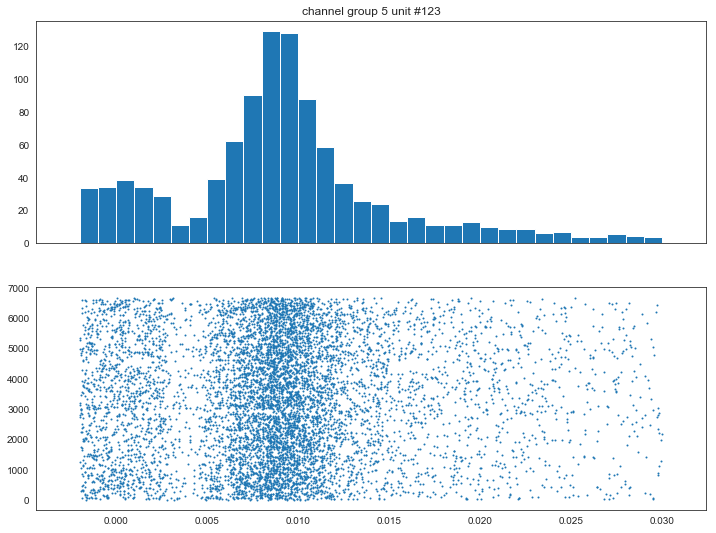

In [371]:
spike_times = get_unit(5, 123)
stim_times = epochs[0]
psth(spike_times, stim_times.times.magnitude, -2e-3, 0.03, 0.001)

In [370]:

spike_times = np.array(unit)

In [ ]:
stim_win = np.insert(
    stim_times,
    np.arange(len(stim_times)) + 1,
    stim_times + y_mu + y_sigma)
src_y = np.searchsorted(y, stim_win, side='left')